In [1]:
import cmdstanpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from cmdstanpy import CmdStanModel, cmdstan_path
import pickle
from hashlib import md5
import json
import arviz as az
import sys
sys.path.append("/home/dashadower/git_repos/aria/")
from scipy.interpolate import splev
from sklearn.metrics import mean_squared_error
from aria.utils.evaluation import smape
from sklearn.preprocessing import PowerTransformer

In [2]:
y_data = pd.read_csv(os.path.realpath("data/y_count_pwr.csv"), usecols=["y"])
age_data = pd.read_csv(os.path.realpath("data/age_pwr.csv"), usecols=["age"])
ship_data = pd.read_csv(os.path.realpath("data/ship_pwr.csv"), usecols=["ship"])
engine_data = pd.read_csv(os.path.realpath("data/engine_pwr.csv"), usecols=["engine"])
ship_engine_mapping_data = pd.read_csv(os.path.realpath("data/ship2engine_pwr.csv"), usecols=["engine"])

In [3]:
engine_count = np.max(engine_data["engine"])
ship_count = np.max(ship_data["ship"])
max_age = np.max(age_data["age"])
data_count = y_data.shape[0]
engine_count, ship_count, max_age, data_count

(5, 99, 31, 653)

# gaussian process model

In [4]:
gp_model_dir = "gaussian_process/stancode/hier_gp_weak.stan"
gp_model = CmdStanModel(stan_file=gp_model_dir) #compile_model(layer3_path)

INFO:cmdstanpy:compiling stan program, exe file: /home/dashadower/git_repos/aria/regression/failure_bma/gaussian_process/stancode/hier_gp_weak
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/gaussian_process/stancode/hier_gp_weak


In [5]:
data = {
    "N": int(data_count),
    "N_engines": int(engine_count),
    "N_ships": int(ship_count),
    "N_ages_obs": int(max_age),
    "N_ages": int(max_age),
    "ship_engine_ind": ship_engine_mapping_data["engine"].values.tolist(),
    "ship_ind": ship_data["ship"].values.tolist(),
    "age_ind": age_data["age"].values.tolist(),
    "y": y_data["y"].values.tolist(),
}

In [6]:
%%time
gp_model_fit = gp_model.sample(chains=4, cores=4, data=data)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1


CPU times: user 1.03 s, sys: 64.6 ms, total: 1.09 s
Wall time: 1min 37s


In [7]:
gp_az_inference = az.from_cmdstanpy(gp_model_fit, posterior_predictive="y_new_pred", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

# spline model

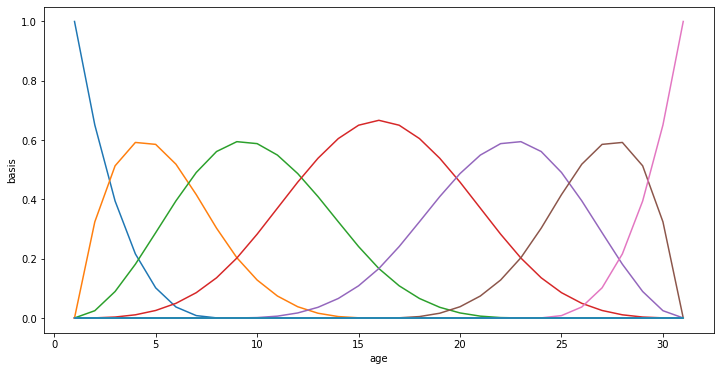

In [8]:
degree = 3
knots = np.linspace(1, 31, num=5)
knots_padded = np.concatenate((np.full(degree, 1), knots, np.full(degree, 31)))

basis = []
for i in range(knots_padded.shape[0]):
    c = np.zeros(knots_padded.shape[0])
    c[i] = 1
    basis.append(splev(np.arange(1, 32), (knots_padded, c, degree)))
basis_df = pd.DataFrame(basis).transpose().set_index(np.arange(1, 32))

fig, ax = plt.subplots(figsize=(12, 6))
ax.set_xlabel('age')
ax.set_ylabel('basis')
basis_df.plot(ax=ax, legend=False)

In [9]:
spline_model_file = os.path.join('hierarchical_model/stancode','layer3_nc_diffsd_parammubar.stan')
layer3_model = CmdStanModel(stan_file=spline_model_file) #compile_model(layer3_path)

INFO:cmdstanpy:compiling stan program, exe file: /home/dashadower/git_repos/aria/regression/failure_bma/hierarchical_model/stancode/layer3_nc_diffsd_parammubar
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/dashadower/git_repos/aria/regression/failure_bma/hierarchical_model/stancode/layer3_nc_diffsd_parammubar


In [10]:
data = {
    "K" : basis_df.shape[1],
    "N" : int(data_count),  # number of total values
    "T" : int(max_age),  # length of time of data(31)
    "S" : int(ship_count), #failure_df.shape[1],  # number of ships(99)
    "E" : int(engine_count),  # number of unique engines
    "age": age_data["age"].values.tolist(),
    "engine": ship_engine_mapping_data["engine"].values.tolist(),  # engine type mapping
    "ship": ship_data["ship"].values.tolist(),#[int(i) for i in np.where(~np.isnan(failure_df).transpose())[0] + 1],  # ship type mapping
    "Y": y_data["y"].values.tolist(),#failure_df.values[~np.isnan(failure_df)].tolist(),  # all values to list
    "B": basis_df.values.tolist(),  # spline values, 2d list
    "N_hat": int(data_count),
    "age_hat": age_data["age"].values.tolist(),
    "ship_hat": ship_data["ship"].values.tolist(),
}

In [11]:
spline_model_fit = layer3_model.sample(chains=4, cores=4, data=data, adapt_delta=0.8)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1


In [12]:
spline_az_inference = az.from_cmdstanpy(spline_model_fit, posterior_predictive="y_new_pred", log_likelihood="log_lik", observed_data={"y": y_data["y"].values.tolist()})

# check out arviz stuff

In [13]:
gp_az_inference

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [14]:
spline_az_inference

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

In [15]:
import logging
logger=  logging.getLogger()
logger.setLevel(logging.INFO)
az.compare({"gaussian_process": gp_az_inference, "spline": spline_az_inference})

/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:151: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  "\nThe scale is now log by default. Use 'scale' argument or "
/home/dashadower/git_repos/aria/venv/lib/python3.6/site-packages/arviz/stats/stats.py:683: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


rank      loo    p_loo    d_loo       weight       se  \
gaussian_process    0 -789.931  123.777        0            1  18.1669   
spline              1 -861.222  9.90793  71.2913  3.96465e-16  17.2522   

                      dse warning loo_scale  
gaussian_process        0    True       log  
spline            14.4459   False       log

In [16]:
#np.any(np.isnan(gp_model_fit.get_drawset(params=["log_lik"]).values))
pd.set_option('display.max_rows', None)
az.summary(gp_az_inference)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
GP_engine_std[0,0]  -0.559  0.885  -2.310    1.025      0.013    0.012   
GP_engine_std[0,1]  -0.002  0.999  -1.807    1.991      0.014    0.017   
GP_engine_std[0,2]  -0.121  0.994  -1.916    1.829      0.014    0.018   
GP_engine_std[0,3]  -0.233  0.735  -1.650    1.111      0.013    0.011   
GP_engine_std[0,4]   0.048  0.798  -1.501    1.511      0.012    0.012   
GP_engine_std[1,0]  -0.747  0.912  -2.405    1.027      0.013    0.012   
GP_engine_std[1,1]  -0.091  0.953  -1.785    1.797      0.012    0.016   
GP_engine_std[1,2]  -0.236  0.976  -2.109    1.627      0.013    0.016   
GP_engine_std[1,3]   1.290  0.830  -0.304    2.832      0.017    0.012   
GP_engine_std[1,4]  -0.115  0.916  -1.854    1.548      0.012    0.015   
GP_engine_std[2,0]  -0.494  0.922  -2.267    1.118      0.014    0.014   
GP_engine_std[2,1]  -0.176  0.962  -1.847    1.746      0.012    0.017   
GP_engine_std[2,2]  -0.190  0.954  -1.940    1.668      0.012    0.016   
GP_engine_std[2,3]  -0.357  0.971  -2.095    1.533      0.018    0.016   
GP_engine_std[2,4]  -0.190  0.976  -1.961    1.621      0.013    0.015   
GP_engine_std[3,0]  -0.135  0.932  -1.941    1.541      0.012    0.015   
GP_engine_std[3,1]  -0.172  0.962  -1.932    1.623      0.012    0.016   
GP_engine_std[3,2]  -0.087  0.969  -1.854    1.719      0.013    0.016   
GP_engine_std[3,3]  -0.400  1.019  -2.306    1.503      0.017    0.015   
GP_engine_std[3,4]  -0.068  0.960  -1.841    1.733      0.012    0.017   
GP_engine_std[4,0]  -0.039  0.976  -1.785    1.853      0.013    0.017   
GP_engine_std[4,1]  -0.194  0.962  -1.918    1.717      0.012    0.016   
GP_engine_std[4,2]  -0.039  0.968  -1.836    1.706      0.012    0.017   
GP_engine_std[4,3]  -0.391  1.024  -2.220    1.597      0.016    0.015   
GP_engine_std[4,4]  -0.010  0.966  -1.730    1.880      0.011    0.017   
GP_engine_std[5,0]   0.028  0.950  -1.712    1.858      0.011    0.016   
GP_engine_std[5,1]  -0.139  0.961  -1.967    1.630      0.012    0.019   
GP_engine_std[5,2]  -0.022  0.969  -1.781    1.886      0.013    0.019   
GP_engine_std[5,3]  -0.253  1.008  -2.100    1.714      0.013    0.017   
GP_engine_std[5,4]  -0.051  0.990  -1.919    1.730      0.014    0.017   
GP_engine_std[6,0]   0.106  0.949  -1.612    2.011      0.012    0.016   
GP_engine_std[6,1]  -0.149  0.955  -1.873    1.711      0.013    0.016   
GP_engine_std[6,2]   0.040  0.962  -1.675    1.876      0.013    0.016   
GP_engine_std[6,3]  -0.187  0.993  -1.972    1.778      0.013    0.018   
GP_engine_std[6,4]   0.009  0.992  -1.744    1.930      0.013    0.017   
GP_engine_std[7,0]   0.126  0.991  -1.702    1.986      0.012    0.018   
GP_engine_std[7,1]  -0.118  0.987  -2.023    1.732      0.013    0.017   
GP_engine_std[7,2]   0.051  0.969  -1.780    1.839      0.014    0.018   
GP_engine_std[7,3]  -0.118  0.978  -2.032    1.626      0.013    0.016   
GP_engine_std[7,4]  -0.025  1.003  -1.846    1.831      0.012    0.018   
GP_engine_std[8,0]   0.143  0.987  -1.599    2.067      0.013    0.018   
GP_engine_std[8,1]  -0.067  0.959  -1.840    1.696      0.013    0.016   
GP_engine_std[8,2]   0.045  0.945  -1.770    1.795      0.012    0.016   
GP_engine_std[8,3]  -0.042  0.998  -1.853    1.822      0.012    0.016   
GP_engine_std[8,4]   0.009  0.987  -1.886    1.819      0.012    0.017   
GP_engine_std[9,0]   0.135  0.961  -1.726    1.945      0.013    0.016   
GP_engine_std[9,1]  -0.021  0.951  -1.771    1.758      0.012    0.017   
GP_engine_std[9,2]   0.032  0.983  -1.715    1.948      0.012    0.017   
GP_engine_std[9,3]  -0.023  0.982  -1.809    1.880      0.013    0.018   
GP_engine_std[9,4]   0.021  0.993  -1.820    1.828      0.012    0.017   
GP_engine_std[10,0]  0.088  0.981  -1.722    1.963      0.012    0.016   
GP_engine_std[10,1]  0.030  0.977  -1.757    1.824      0.012    0.017   
GP_engine_std[10,2]  0.014  0.978  -1.782    1.843      0.013    0.017   
GP_engine_std[10,3] -0.008

In [17]:
pd.reset_option('display.max_rows')

In [18]:
#np.any(np.isnan(gp_model_fit.get_drawset(params=["log_lik"]).values))